# Simple Bayesian Regression with Stan

$$
\begin{align}
    \nonumber \sigma^2 &\sim \text{Inv-Gamma(1,1)}\\
    \nonumber \alpha &\sim \mathcal{N}(0,10)\\
    \nonumber \beta &\sim \mathcal{N}(0,10)\\
    \nonumber y_n &\sim \mathcal{N}(\alpha + \beta x_n, \sigma^2), \text{ for } n=1,\dots,N\\
\end{align}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

## Simulation of Data Set

In [2]:
N = 500
sigma = 2.0
alpha = 4.3
beta = 6.0
x = np.random.normal(size=N)
y = alpha + beta * x + sigma * np.random.normal(size=N)

## Model with Stan

In [3]:
program_code = """

data {
    int<lower=1> N;
    vector[N] y;
    vector[N] x;
}

parameters {
    real alpha;
    real beta;
    real<lower=0> sigma2;
}

transformed parameters {
    real<lower=0> sigma;
    sigma = sqrt(sigma2);
}

model {
    alpha ~ normal(0, 10);
    beta ~ normal(0, 10);
    sigma ~ inv_gamma(1, 1);

    y ~ normal(alpha + beta * x, sigma);
}

"""

data_dict = {
    'y': y,
    'x': x,
    'N': N
}

In [4]:
### Build model
model = stan.build(program_code=program_code, data=data_dict)

Building...



Building: found in cache, done.

In [5]:
### Fit model
fit = model.sample(num_chains=4, num_samples=1000, num_warmup=500)

Sampling:   0%


Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 8.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.86 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.84 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.73 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.19 seconds.
  Adjust your expectations accordingly!


In [6]:
fit.to_frame().head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta,sigma2,sigma
draws,,,,,,,,,,,
0,-610.087673,0.924709,0.700231,3.0,7.0,0.0,612.310159,4.227202,5.934546,3.731434,1.931692
1,-607.982022,0.859140,0.760563,3.0,7.0,0.0,609.736434,4.271416,5.967940,4.132914,2.032957
2,-608.262597,1.000000,0.867755,2.0,3.0,0.0,610.666850,4.280395,6.000157,3.981612,1.995398
3,-610.176806,0.814659,0.772729,2.0,3.0,0.0,612.046247,4.358495,5.792306,4.361870,2.088509
4,-610.097740,0.952135,0.700231,3.0,7.0,0.0,612.461264,4.494760,5.998836,4.325721,2.079837


In [7]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,4.306,0.090,4.135,4.474,0.001,0.001,3806.0,2836.0,1.0
beta,5.975,0.093,5.801,6.149,0.001,0.001,4068.0,2803.0,1.0
sigma2,4.214,0.275,3.690,4.720,0.004,0.003,3956.0,2695.0,1.0
sigma,2.052,0.067,1.921,2.173,0.001,0.001,3956.0,2695.0,1.0


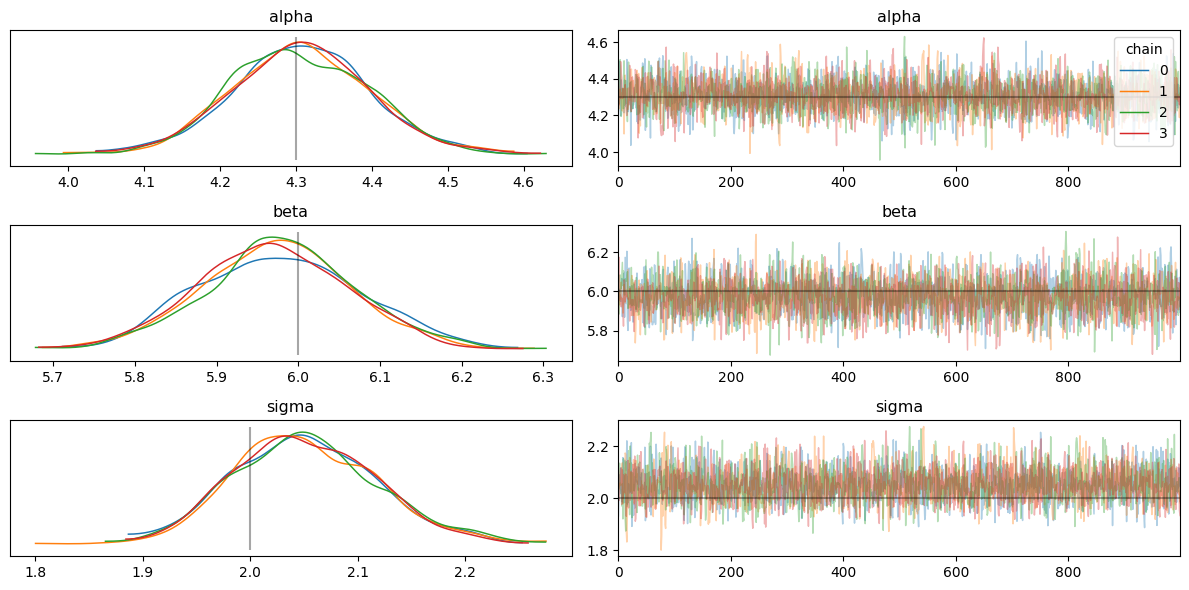

In [8]:
### Visual inspection and diagnostics
lines = [('alpha', {}, [alpha]), ('beta', {}, [beta]), ('sigma', {}, [sigma])]
az.plot_trace(fit, var_names=['alpha', 'beta', 'sigma'], compact=False, legend=True, lines=lines)
plt.tight_layout()

## Analysis

Based on the graphs above, the posterior means are fairly accurate. The vertical lines show the true values for $\alpha$, $\beta$, and $\sigma$. There is still some uncertainty (the standard deviations for $\alpha$ and $\beta$ are around 0.09 and is 0.0.067 for $\sigma$) but it is very reasonable.

## Increasing $N$

In [9]:
N *= 10
x = np.random.normal(size=N)
y = alpha + beta * x + sigma * np.random.normal(size=N)

In [10]:
data_dict = {
    'y': y,
    'x': x,
    'N': N
}

model = stan.build(program_code=program_code, data=data_dict)

fit = model.sample(num_chains=4, num_samples=1000, num_warmup=500)

Building...



Building: found in cache, done.Sampling:   0%
Sampling:   5% (300/6000)
Sampling:  10% (600/6000)
Sampling:  35% (2100/6000)
Sampling:  60% (3600/6000)
Sampling:  80% (4800/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.000319 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.19 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000398 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.98 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000338 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.38 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000101 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.01 seconds.
  Adjust your expectations accordingly!


In [11]:
fit.to_frame().head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta,sigma2,sigma
draws,,,,,,,,,,,
0,-5948.981077,0.913390,0.726598,2.0,3.0,0.0,5952.710297,4.344031,6.025309,4.023029,2.005749
1,-5945.442815,1.000000,0.686394,2.0,3.0,0.0,5948.126156,4.263228,5.964760,3.999008,1.999752
2,-5946.365347,0.854133,0.860477,2.0,3.0,0.0,5946.375883,4.341274,5.977758,3.947358,1.986796
3,-5946.026287,0.993077,0.858531,3.0,7.0,0.0,5947.725487,4.254535,5.972506,4.021674,2.005411
4,-5945.817116,1.000000,0.726598,3.0,7.0,0.0,5949.127438,4.324912,5.977856,4.028611,2.007140


In [12]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,4.293,0.029,4.244,4.351,0.000,0.000,3913.0,2854.0,1.0
beta,5.964,0.029,5.910,6.016,0.000,0.000,4304.0,2794.0,1.0
sigma2,3.969,0.078,3.829,4.116,0.001,0.001,3713.0,3043.0,1.0
sigma,1.992,0.020,1.957,2.029,0.000,0.000,3713.0,3043.0,1.0


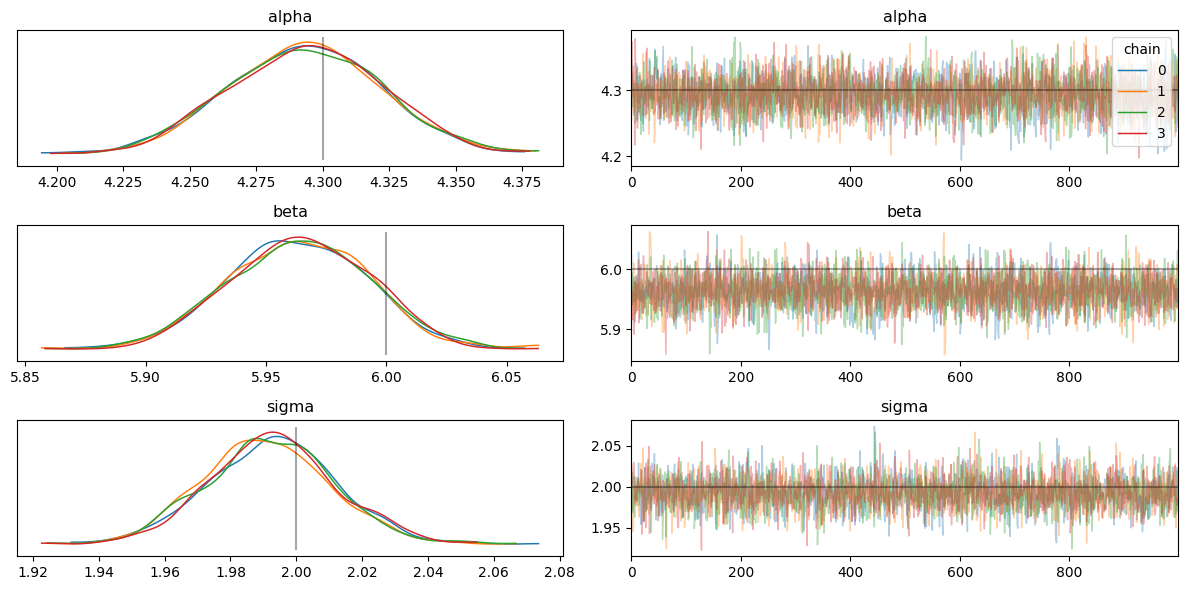

In [13]:
lines = [('alpha', {}, [alpha]), ('beta', {}, [beta]), ('sigma', {}, [sigma])]
az.plot_trace(fit, var_names=['alpha', 'beta', 'sigma'], compact=False, legend=True, lines=lines)
plt.tight_layout()

## Analysis

After increasing $N$ by a factor of 10, the precision has not changed much. $\beta$ drifted a bit farther from the actual value, but only by 0.011. The uncertainty has decreased, though. The standard deviation for $\alpha$, $\beta$, and $\sigma$ are all about 3 times smaller than they were before.